##### Imports

In [1]:
# %pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, Tuple
from scipy.stats import norm, invgamma, multivariate_normal
import pickle
import os

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

warnings.filterwarnings('ignore')

from regime_detection import KAMA
from regime_detection import MarkovSwitchingModel
from regime_detection import KAMA_MSR
# from kama_msr_model_improved import KAMA
# from kama_msr_model_improved import MarkovSwitchingModel
# from kama_msr_model_improved import KAMA_MSR

# Getting Price Data

In [3]:
# Prepare data
international_index_symbol_names = pd.read_csv('data/inputs/fmp_index_list.csv').set_index('symbol')['name']
international_index_symbol_names = international_index_symbol_names[~international_index_symbol_names.index.isin(['^GSPC', '^NDX'])].to_dict()
commodity_symbol_names = pd.read_csv('data/inputs/fmp_commodity_list.csv').set_index('symbol')['name'].to_dict()
us_traded_symbol_names = {
    # BOND ETFS
    'BIL': 'SPDR Bloomberg 1-3 Month T-Bill ETF',
    'SHY': 'iShares 1-3 Year Treasury Bond ETF',
    'IEF': 'iShares 7-10 Year Treasury Bond ETF',
    # International EQUITY ETFS
    'VXUS': 'Vanguard Total International Stock ETF',
    'VEA': 'Vanguard FTSE Developed Markets ETF',
    'VWO': 'Vanguard FTSE Emerging Markets ETF',
    'VGK': 'Vanguard FTSE Europe ETF',
    'VPL': 'Vanguard FTSE Pacific ETF',
    'FXI': 'iShares China Large-Cap ETF',
    'EWJ': 'iShares MSCI Japan ETF',
    'INDA': 'iShares MSCI India ETF',
    # MAJOR INDICES
    '^GSPC': 'S&P 500',
    '^IXIC': 'Nasdaq Composite',
    '^NDX': 'Nasdaq 100',
    '^RUT': 'Russell 2000',
    '^DJI': 'Dow Jones Industrial Average',
    '^RUI': 'Russell 1000',
    '^RUA': 'Russell 3000',
    
    # MAIN BROAD MARKET ETFS
    'SPY': 'SPDR S&P 500 ETF',
    'VOO': 'Vanguard S&P 500 ETF',
    'RSP': 'Invesco S&P 500 Equal Weight ETF',
    'IVV': 'iShares Core S&P 500 ETF',
    'QQQ': 'Invesco QQQ Trust',
    'QQQM': 'Invesco Nasdaq 100 ETF',
    'ONEQ': 'Fidelity Nasdaq Composite Index ETF',
    'IWM': 'iShares Russell 2000 ETF',
    'IWB': 'iShares Russell 1000 ETF',
    'IWV': 'iShares Russell 3000 ETF',
    'DIA': 'SPDR Dow Jones Industrial Average ETF',
    'VTI': 'Vanguard Total Stock Market ETF',
    
    # S&P 500 SECTOR ETFS (SELECT SECTOR SPDRS)
    'XLE': 'Energy Select Sector SPDR',
    'XLF': 'Financial Select Sector SPDR',
    'XLU': 'Utilities Select Sector SPDR',
    'XLI': 'Industrial Select Sector SPDR',
    'XLV': 'Health Care Select Sector SPDR',
    'XLK': 'Technology Select Sector SPDR',
    'XLB': 'Materials Select Sector SPDR',
    'XLY': 'Consumer Discretionary Select Sector SPDR',
    'XLP': 'Consumer Staples Select Sector SPDR',
    'XLRE': 'Real Estate Select Sector SPDR',
    'XLC': 'Communication Services Select Sector SPDR',
    
    # GROWTH ETFs
    'IVW': 'iShares S&P 500 Growth ETF',
    'VONG': 'Vanguard Russell 1000 Growth ETF',
    'IWF': 'iShares Russell 1000 Growth ETF',
    'IWO': 'iShares Russell 2000 Growth ETF',
    'VUG': 'Vanguard Growth ETF',
    'SPYG': 'SPDR Portfolio S&P 500 Growth ETF',
    
    # VALUE ETFs
    'IVE': 'iShares S&P 500 Value ETF',
    'VONV': 'Vanguard Russell 1000 Value ETF',
    'IWD': 'iShares Russell 1000 Value ETF',
    'IWN': 'iShares Russell 2000 Value ETF',
    'VTV': 'Vanguard Value ETF',
    'SPYV': 'SPDR Portfolio S&P 500 Value ETF',
    
    # SIZE ETFs
    'IWR': 'iShares Russell Mid-Cap ETF',
    'IWC': 'iShares Micro-Cap ETF',
    'IJH': 'iShares Core S&P Mid-Cap ETF',
    'IJR': 'iShares Core S&P Small-Cap ETF',
    'MDY': 'SPDR S&P MidCap 400 ETF',
    'SLY': 'SPDR S&P 600 Small Cap ETF',
    'VO': 'Vanguard Mid-Cap ETF',
    'VB': 'Vanguard Small-Cap ETF',
    'SCHA': 'Schwab U.S. Small-Cap ETF',
    'SCHM': 'Schwab U.S. Mid-Cap ETF',
    'VTWO': 'Vanguard Russell 2000 ETF',
    'VTHR': 'Vanguard Russell 3000 ETF',
    'THRK': 'iShares Russell 3000 ETF',
    'SPSM': 'SPDR Portfolio S&P 600 Small Cap ETF',
    'SMLF': 'iShares Small-Cap US Equity Factor ETF',
    
    # NASDAQ SPECIFIC
    'QTEC': 'First Trust Nasdaq-100 Technology Sector Index Fund',
    'QQEW': 'First Trust Nasdaq-100 Equal Weighted Index Fund',
    'QQQG': 'Pacer Nasdaq 100 Top 50 Cash Cows Dividend Growth ETF',
    'QQQV': 'Pacer Nasdaq 100 Top 50 Value ETF',
    
    # DIVIDEND/QUALITY
    'SCHD': 'Schwab U.S. Dividend Equity ETF',
    'VYM': 'Vanguard High Dividend Yield ETF',
    'DVY': 'iShares Select Dividend ETF',
    'QUAL': 'iShares MSCI USA Quality Factor ETF',
    'USMV': 'iShares MSCI USA Min Vol Factor ETF',
    
    # EQUAL WEIGHT
    'EWSC': 'Invesco S&P SmallCap 600 Equal Weight ETF',
    'EWMC': 'Invesco S&P MidCap 400 Equal Weight ETF',
}

international_index_data = pd.read_csv('data/processed/index_data.csv', index_col=0, header=[0, 1], parse_dates=True)
commodity_data = pd.read_csv('data/processed/commodity_data.csv', index_col=0, header=[0, 1], parse_dates=True)
us_traded_data = pd.read_csv('data/processed/us_equity_all_data.csv', index_col=0, header=[0, 1], parse_dates=True)

international_index_close_cols = international_index_data.columns[international_index_data.columns.get_level_values(1) == 'close']
international_index_close_prices = international_index_data[international_index_close_cols].droplevel(1, axis=1).rename(columns=international_index_symbol_names)
international_index_close_prices = international_index_close_prices[international_index_close_prices.columns[international_index_close_prices.columns.isin(['S&P 500', 'NASDAQ 100']) == False]]
international_index_close_prices.columns = [col.replace('/', ' ') for col in international_index_close_prices.columns]

commodity_data_close_cols = commodity_data.columns[commodity_data.columns.get_level_values(1) == 'close']
commodity_close_prices = commodity_data[commodity_data_close_cols].droplevel(1, axis=1).rename(columns=commodity_symbol_names)
commodity_close_prices.columns = [col.replace('/', ' ') for col in commodity_close_prices.columns]

us_traded_close_cols = us_traded_data.columns[us_traded_data.columns.get_level_values(1) == 'close']
us_traded_close_prices = us_traded_data[us_traded_close_cols].droplevel(1, axis=1).rename(columns=us_traded_symbol_names)
us_traded_close_prices

# print('US Traded Assets & Indices:', us_traded_close_prices.columns.tolist())
print('International Indices:', international_index_close_prices.columns.tolist())
print('Commodities:', commodity_close_prices.columns.tolist())

International Indices: ['S&P TSX Composite Index', 'TSEC Weighted Index', 'S&P ASX 200', '^GSPC', 'Nikkei 225', 'KOSPI Composite Index', 'FTSE MIB Index', 'FTSE 100', 'SMI PR', 'NIFTY 50', '^NDX', 'DAX Performance Index', 'CAC 40', 'MSCI_China']
Commodities: ['Aluminum Futures', 'Gold Futures', 'Wheat Futures', 'Corn Futures', 'Copper', 'Sugar', 'Soybean Futures', 'Live Cattle Futures', 'Natural Gas', 'Coffee', 'Brent Crude Oil', 'Nickel']


In [4]:
us_traded_always_disclude = ['Vanguard S&P 500 ETF', 'Real Estate Select Sector SPDR', 'Communication Services Select Sector SPDR']
us_traded_disclude = [name for name in us_traded_close_prices.columns if 'Russell 1000' in name or 'Russell 3000' in name]

us_traded_include = list(set(us_traded_close_prices.columns.tolist()) - set(us_traded_always_disclude) - set(us_traded_disclude))
us_traded_close_prices = us_traded_close_prices[us_traded_include]

us_bond = ['SPDR Bloomberg 1-3 Month T-Bill ETF', 'iShares 1-3 Year Treasury Bond ETF', 'iShares 7-10 Year Treasury Bond ETF']
us_traded_international_equity_etfs = ['Vanguard Total International Stock ETF', 'Vanguard FTSE Developed Markets ETF',\
                                        'Vanguard FTSE Emerging Markets ETF','Vanguard FTSE Europe ETF',\
                                        'Vanguard FTSE Pacific ETF', 'iShares China Large-Cap ETF',\
                                        'iShares MSCI Japan ETF', 'iShares MSCI India ETF',]
us_equity = list(set(us_traded_include) - set(us_bond) - set(us_traded_international_equity_etfs))
print('US Equity:', us_equity)
print('US Bond:', us_bond)
print('US Traded International Equity ETFs:', us_traded_international_equity_etfs)

US Equity: ['Nasdaq 100', 'Invesco S&P 500 Equal Weight ETF', 'Consumer Discretionary Select Sector SPDR', 'iShares Russell 2000 ETF', 'Russell 2000', 'iShares Micro-Cap ETF', 'iShares Russell Mid-Cap ETF', 'Invesco QQQ Trust', 'S&P 500', 'Industrial Select Sector SPDR', 'Consumer Staples Select Sector SPDR', 'Dow Jones Industrial Average', 'Utilities Select Sector SPDR', 'Health Care Select Sector SPDR', 'iShares S&P 500 Value ETF', 'SPDR S&P 500 ETF', 'Materials Select Sector SPDR', 'Energy Select Sector SPDR', 'iShares Russell 2000 Value ETF', 'Fidelity Nasdaq Composite Index ETF', 'SPDR Dow Jones Industrial Average ETF', 'Technology Select Sector SPDR', 'iShares S&P 500 Growth ETF', 'Nasdaq Composite', 'iShares Russell 2000 Growth ETF', 'Financial Select Sector SPDR']
US Bond: ['SPDR Bloomberg 1-3 Month T-Bill ETF', 'iShares 1-3 Year Treasury Bond ETF', 'iShares 7-10 Year Treasury Bond ETF']
US Traded International Equity ETFs: ['Vanguard Total International Stock ETF', 'Vanguard F

# Inputs

In [12]:
# Inputs
sdte = datetime(1990, 1, 1)
edte = datetime(2022, 1, 1)
asset_names = us_traded_international_equity_etfs
close_prices = us_traded_close_prices
asset_type_sub_folder = 'us_traded_international_equity_etfs'
n_regimes=2
use_three_state_msr = (n_regimes == 3)
kama_params = {'n': 10, 'n_fast': 2, 'n_slow': 30}
filter_params = {'n_lookback': 20, 'gamma': 0.7}
n_samples=1000
burnin=200
thin=1

# Fitting KAMA+MSR

In [13]:
def fit_KAMA_MSR(sdte: datetime | str, 
                 edte: datetime | str,
                 asset_names: list[str],
                 n_regimes: int,
                 use_three_state_msr: bool,
                 kama_params: Dict,
                 filter_params: Dict,
                 n_samples: int,
                 burnin: int,
                 thin: int,
                 close_prices: pd.DataFrame,
                 # NEW PARAMETERS FOR IMPROVEMENTS
                 optimize_kama: bool = False,
                 kama_optimization_method: str = 'random',
                 n_random_trials: int = 50,
                 min_regime_duration: int | None = None,
                 duration_enforcement_method: str = 'extend',
                 random_seed: int | None = None,
                 msr_verbose: bool = True) -> Dict[str, 'KAMA_MSR']:
    """
    Fit KAMA+MSR models with improved optimization and duration enforcement.
    
    Parameters:
    -----------
    sdte : datetime | str
        Start date for data
    edte : datetime | str
        End date for data
    asset_names : list[str]
        List of asset names to process
    n_regimes : int
        Number of MSR regimes (2 or 3)
    use_three_state_msr : bool
        Whether to use 3-state MSR
    kama_params : dict
        Initial KAMA parameters (will be overridden if optimize_kama=True)
    filter_params : dict
        Filter parameters
    n_samples : int
        Number of MCMC samples
    burnin : int
        MCMC burnin period
    thin : int
        MCMC thinning
    close_prices : pd.DataFrame
        DataFrame of close prices
    
    NEW PARAMETERS:
    ---------------
    optimize_kama : bool, default=False
        Whether to optimize KAMA parameters using misclassification score
    kama_optimization_method : str, default='random'
        Optimization method: 'random' (fast) or 'coarse_to_fine' (thorough)
    n_random_trials : int, default=50
        Number of random trials for optimization (if method='random')
    optimize_filter : bool, default=False
        Whether to optimize filter parameters
    min_regime_duration : int | None, default=None
        Minimum number of periods a regime must persist
        If None, no duration enforcement
    duration_enforcement_method : str, default='extend'
        Method for duration enforcement: 'extend', 'merge', or 'majority'
    random_seed : int | None, default=None
        Random seed for reproducibility
    msr_verbose : bool, default=True
        Whether to print MSR fitting progress
    
    Returns:
    --------
    Dict[str, KAMA_MSR] : Dictionary of fitted models by asset name
    """
    models = {}
    
    for asset_name in asset_names:
        if asset_name not in close_prices.columns:
            print(f"Asset name {asset_name} not found in provided close prices data. Skipping.")
            continue
        
        print(f"\n{'='*160}")
        print(f"PROCESSING: {asset_name}")
        print(f"{'='*160}")

        # Prepare data
        prices = close_prices[asset_name].dropna()
        prices = prices.loc[sdte:edte]
        
        # Initialize model
        model = KAMA_MSR(
            kama_params=kama_params,
            msr_params={'n_regimes': n_regimes},
            filter_params=filter_params,
            use_three_state_msr=use_three_state_msr,
            random_seed=random_seed  # NEW: Set random seed
        )
        
        # Fit the model with improvements
        model.fit(
            asset_name=asset_name,
            prices=prices,
            
            # NEW: KAMA optimization using misclassification score
            optimize_kama=optimize_kama,
            kama_optimization_method=kama_optimization_method,
            n_random_trials=n_random_trials,
            
            # # Filter optimization (optional)
            # optimize_filter=optimize_filter,
            
            # NEW: Minimum regime duration enforcement
            min_regime_duration=min_regime_duration,
            duration_enforcement_method=duration_enforcement_method,
            
            # MSR parameters
            msr_verbose=msr_verbose,
            n_samples=n_samples,
            burnin=burnin,
            thin=thin
        )
        
        # Print summary statistics
        print(f"\n{'='*80}")
        print(f"SUMMARY FOR {asset_name}")
        print(f"{'='*80}")
        
        if optimize_kama:
            print(f"Optimized KAMA: n={model.kama.n}, n_fast={model.kama.n_fast}, "
                  f"n_slow={model.kama.n_slow}, gamma={model.gamma:.3f}")
        
        if min_regime_duration is not None:
            print(f"\nDuration Statistics:")
            print(model.analyze_regime_durations().to_string(index=False))
        
        print(f"\nRegime Distribution:")
        regime_counts = model.regime_labels.value_counts().sort_index()
        total = len(model.regime_labels)
        for regime, count in regime_counts.items():
            print(f"  Regime {regime}: {count:5d} periods ({100*count/total:5.1f}%)")
        
        n_changes = (model.regime_labels.diff() != 0).sum()
        avg_duration = total / (n_changes + 1)
        print(f"\nRegime Changes: {n_changes}")
        print(f"Average Duration: {avg_duration:.1f} periods")
        
        models[asset_name] = model
        
    print(f"\n{'='*80}")
    print(f"COMPLETED FITTING {len(models)} ASSETS")
    print(f"{'='*80}\n")
    
    return models

def save_KAMA_MSR_models(models: Dict[str, 'KAMA_MSR'], 
                         asset_type_sub_folder: str, 
                         edte_sub_folder: str,
                         save_metadata: bool = True) -> None:
    """
    Save fitted KAMA+MSR models with metadata.
    
    Parameters:
    -----------
    models : Dict[str, KAMA_MSR]
        Dictionary of fitted models
    asset_type_sub_folder : str
        Sub-folder for asset type (e.g., 'international_index')
    edte_sub_folder : str
        Sub-folder for end date (e.g., '20230101')
    save_metadata : bool, default=True
        Whether to save metadata file with model info
    """
    save_dir = f'saved_models/KAMA_MSR/{asset_type_sub_folder}/{edte_sub_folder}'
    os.makedirs(save_dir, exist_ok=True)
    
    metadata = {}
    
    for asset_name, model in models.items():
        # Clean asset name for filename
        clean_name = asset_name.replace('/', '_').replace('\\', '_')
        n_regimes = model.msr.n_regimes
        total_regimes = n_regimes * 2
        
        # Save model
        filename = f'{clean_name}_KAMA-MSR_{total_regimes}-regimes.pkl'
        filepath = os.path.join(save_dir, filename)
        
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)
        
        print(f"✓ Saved: {filepath}")
        
        # Collect metadata
        if save_metadata:
            metadata[asset_name] = {
                'filename': filename,
                'n_msr_regimes': n_regimes,
                'n_combined_regimes': total_regimes,
                'kama_params': {
                    'n': model.kama.n,
                    'n_fast': model.kama.n_fast,
                    'n_slow': model.kama.n_slow
                },
                'filter_params': {
                    'n_lookback': model.n_lookback,
                    'gamma': model.gamma
                },
                'min_regime_duration': model.min_regime_duration,
                'duration_method': model.duration_method,
                'n_data_points': len(model.regime_labels),
                'regime_distribution': model.regime_labels.value_counts().to_dict(),
                'n_regime_changes': (model.regime_labels.diff() != 0).sum()
            }
    
    # Save metadata
    if save_metadata and metadata:
        metadata_file = os.path.join(save_dir, 'metadata.pkl')
        with open(metadata_file, 'wb') as f:
            pickle.dump(metadata, f)
        print(f"\n✓ Saved metadata: {metadata_file}")


In [ ]:
models = fit_KAMA_MSR(
    sdte=sdte,
    edte=edte,
    asset_names=asset_names,
    n_regimes=n_regimes,
    use_three_state_msr=False,
    kama_params=kama_params,
    filter_params=filter_params,
    n_samples=n_samples,
    burnin=burnin,
    thin=thin,
    close_prices=close_prices,
    # Full optimization
    optimize_kama=True,
    kama_optimization_method='coarse_to_fine',
    # optimize_filter=True,                   
    min_regime_duration=1,
    duration_enforcement_method='extend',
    random_seed=42,
    msr_verbose=True
)


PROCESSING: Vanguard Total International Stock ETF

KAMA+MSR COMBINED MODEL FITTING for Vanguard Total International Stock ETF
Mode: 4-Regime (2-State MSR)

[1/5] Fitting 2-state MSR model...
Running Gibbs sampler: 1200 total iterations
Burnin: 200, Samples: 1000, Thin: 1
Iteration 100/1200
Iteration 200/1200
Iteration 300/1200
Iteration 400/1200
Iteration 500/1200


In [ ]:
save_KAMA_MSR_models(models, asset_type_sub_folder, edte.strftime('%Y%m%d'), save_metadata=False)

✓ Saved: saved_models/KAMA_MSR/us_bonds/20220101/SPDR Bloomberg 1-3 Month T-Bill ETF_KAMA-MSR_4-regimes.pkl
✓ Saved: saved_models/KAMA_MSR/us_bonds/20220101/iShares 1-3 Year Treasury Bond ETF_KAMA-MSR_4-regimes.pkl
✓ Saved: saved_models/KAMA_MSR/us_bonds/20220101/iShares 7-10 Year Treasury Bond ETF_KAMA-MSR_4-regimes.pkl


In [ ]:
!git add .
!git commit -m f"Auto-commit after model fit for {asset_type_sub_folder} ending {edte.strftime('%Y%m%d')}"
!git push

[Improving-hyperparameter-optimization cb5ccc5] fAuto-commit after model fit for us_bonds ending 20220101
 5 files changed, 260 insertions(+), 38 deletions(-)
 create mode 100644 saved_models/KAMA_MSR/us_bonds/20220101/SPDR Bloomberg 1-3 Month T-Bill ETF_KAMA-MSR_4-regimes.pkl
 create mode 100644 saved_models/KAMA_MSR/us_bonds/20220101/iShares 1-3 Year Treasury Bond ETF_KAMA-MSR_4-regimes.pkl
 create mode 100644 saved_models/KAMA_MSR/us_bonds/20220101/iShares 7-10 Year Treasury Bond ETF_KAMA-MSR_4-regimes.pkl
Enumerating objects: 16, done.
Counting objects: 100% (16/16), done.
Delta compression using up to 8 threads
Compressing objects: 100% (10/10), done.
Writing objects: 100% (11/11), 993.15 KiB | 4.45 MiB/s, done.
Total 11 (delta 5), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (5/5), completed with 3 local objects.
To https://github.com/jessego20/FE800_project_code.git
   fc3d765..cb5ccc5  Improving-hyperparameter-optimization -> Improving-hyperparameter-optimiz

# Load & Analyze Saved Models

In [9]:
def load_and_analyze_KAMA_MSR_model(asset_name: str, n_regimes: int, sub_folder: str, edte_sub_folder: str) -> None:
    pkl_file_path = f'saved_models/KAMA_MSR/{sub_folder}/{edte_sub_folder}/{asset_name}_KAMA-MSR_{n_regimes*2}-regimes.pkl'
    with open(pkl_file_path, 'rb') as f:
        loaded_model = pickle.load(f)

    print("="*80)
    print("LOADED MODEL INFORMATION")
    print("="*80)

    # ============================================================================
    # 2. ACCESS KAMA PARAMETERS
    # ============================================================================
    print("\n2. KAMA PARAMETERS:")
    print("-" * 40)
    print(f"KAMA n: {loaded_model.kama.n}")
    print(f"KAMA n_fast: {loaded_model.kama.n_fast}")
    print(f"KAMA n_slow: {loaded_model.kama.n_slow}")
    print(f"KAMA k_fast: {loaded_model.kama.k_fast:.6f}")
    print(f"KAMA k_slow: {loaded_model.kama.k_slow:.6f}")

    # ============================================================================
    # 3. ACCESS FILTER PARAMETERS
    # ============================================================================
    print("\n3. FILTER PARAMETERS:")
    print("-" * 40)
    print(f"n_lookback: {loaded_model.n_lookback}")
    print(f"gamma: {loaded_model.gamma}")

    # ============================================================================
    # 4. ACCESS PRIORS (AFTER OPTIMIZATION)
    # ============================================================================
    print("\n4. MSR PRIORS:")
    print("-" * 40)

    # The priors used during model initialization
    priors = loaded_model.msr.priors
    for param, value in priors.items():
        print(f"{param}: {value}")

    # ============================================================================
    # 5. ACCESS MODEL CONFIGURATION
    # ============================================================================
    print("\n5. MODEL CONFIGURATION:")
    print("-" * 40)
    print(f"use_three_state_msr: {loaded_model.use_three_state_msr}")
    print(f"Number of combined regimes: {loaded_model.n_combined_regimes}")
    print(f"MSR n_regimes: {loaded_model.msr.n_regimes}")

    # ============================================================================
    # 6. CHECK DATA DIMENSIONS
    # ============================================================================
    print("\n6. DATA INFORMATION:")
    print("-" * 40)
    if loaded_model.prices is not None:
        print(f"Price data length: {len(loaded_model.prices)}")
        print(f"Return data length: {len(loaded_model.returns)}")
        print(f"Regime labels length: {len(loaded_model.regime_labels.dropna())}")
        print(f"Regime changes: {(loaded_model.regime_labels.diff() != 0).sum()}")

    # ============================================================================
    # 7. ACCESS MSR PARAMETERS (AFTER FITTING)
    # ============================================================================
    print("\n7. MSR PARAMETERS (Post-Fit):")
    print("-" * 40)
    print("MSR Means (μ):")
    for i, mean in enumerate(loaded_model.msr.means):
        print(f"  Regime {i}: {mean:.6f}")

    print("\nMSR Betas (β):")
    for i, beta in enumerate(loaded_model.msr.betas):
        print(f"  Regime {i}: {beta:.4f}")

    print("\nMSR Standard Deviations (σ):")
    for i, std in enumerate(loaded_model.msr.stds):
        print(f"  Regime {i}: {std:.6f}")

    print("\nMSR Transition Probabilities:")
    print("          To Regime:")
    print("From      0       1" + ("       2" if loaded_model.msr.n_regimes == 3 else ""))
    print("Regime")
    for i in range(loaded_model.msr.n_regimes):
        row = f"  {i}    "
        for j in range(loaded_model.msr.n_regimes):
            row += f"  {loaded_model.msr.transition_probs[i,j]:.3f}"
        print(row)


    # ============================================================================
    # 8. RUN ANALYSIS ON LOADED MODEL
    # ============================================================================
    print("\n8. RUNNING FULL ANALYSIS ON LOADED MODEL...")
    loaded_model.analyze_results(data_name=asset_name)
    regime_duration_stats = loaded_model.analyze_regime_durations()
    print("\nRegime Duration Statistics:")
    print(regime_duration_stats)
    loaded_model.regime_characteristics(data_name=asset_name)
    loaded_model.plot_regimes()
    # loaded_model.plot_regime_duration_distribution()
    loaded_model.plot_comprehensive_analysis()


LOADED MODEL INFORMATION

2. KAMA PARAMETERS:
----------------------------------------
KAMA n: 6
KAMA n_fast: 10
KAMA n_slow: 20
KAMA k_fast: 0.181818
KAMA k_slow: 0.095238

3. FILTER PARAMETERS:
----------------------------------------
n_lookback: 20
gamma: 0.5

4. MSR PRIORS:
----------------------------------------
mean_prior_mean: 0.0
mean_prior_var: 0.1
beta_prior_mean: 0.0
beta_prior_var: 1.0
sigma_prior_shape: 2.0
sigma_prior_scale: 0.1
transition_prior_alpha: 8.0

5. MODEL CONFIGURATION:
----------------------------------------
use_three_state_msr: False
Number of combined regimes: 4
MSR n_regimes: 2

6. DATA INFORMATION:
----------------------------------------
Price data length: 4894
Return data length: 4893
Regime labels length: 4874
Regime changes: 117

7. MSR PARAMETERS (Post-Fit):
----------------------------------------
MSR Means (μ):
  Regime 0: 0.000010
  Regime 1: -0.003694

MSR Betas (β):
  Regime 0: -0.0005
  Regime 1: -0.0352

MSR Standard Deviations (σ):
  Regime 

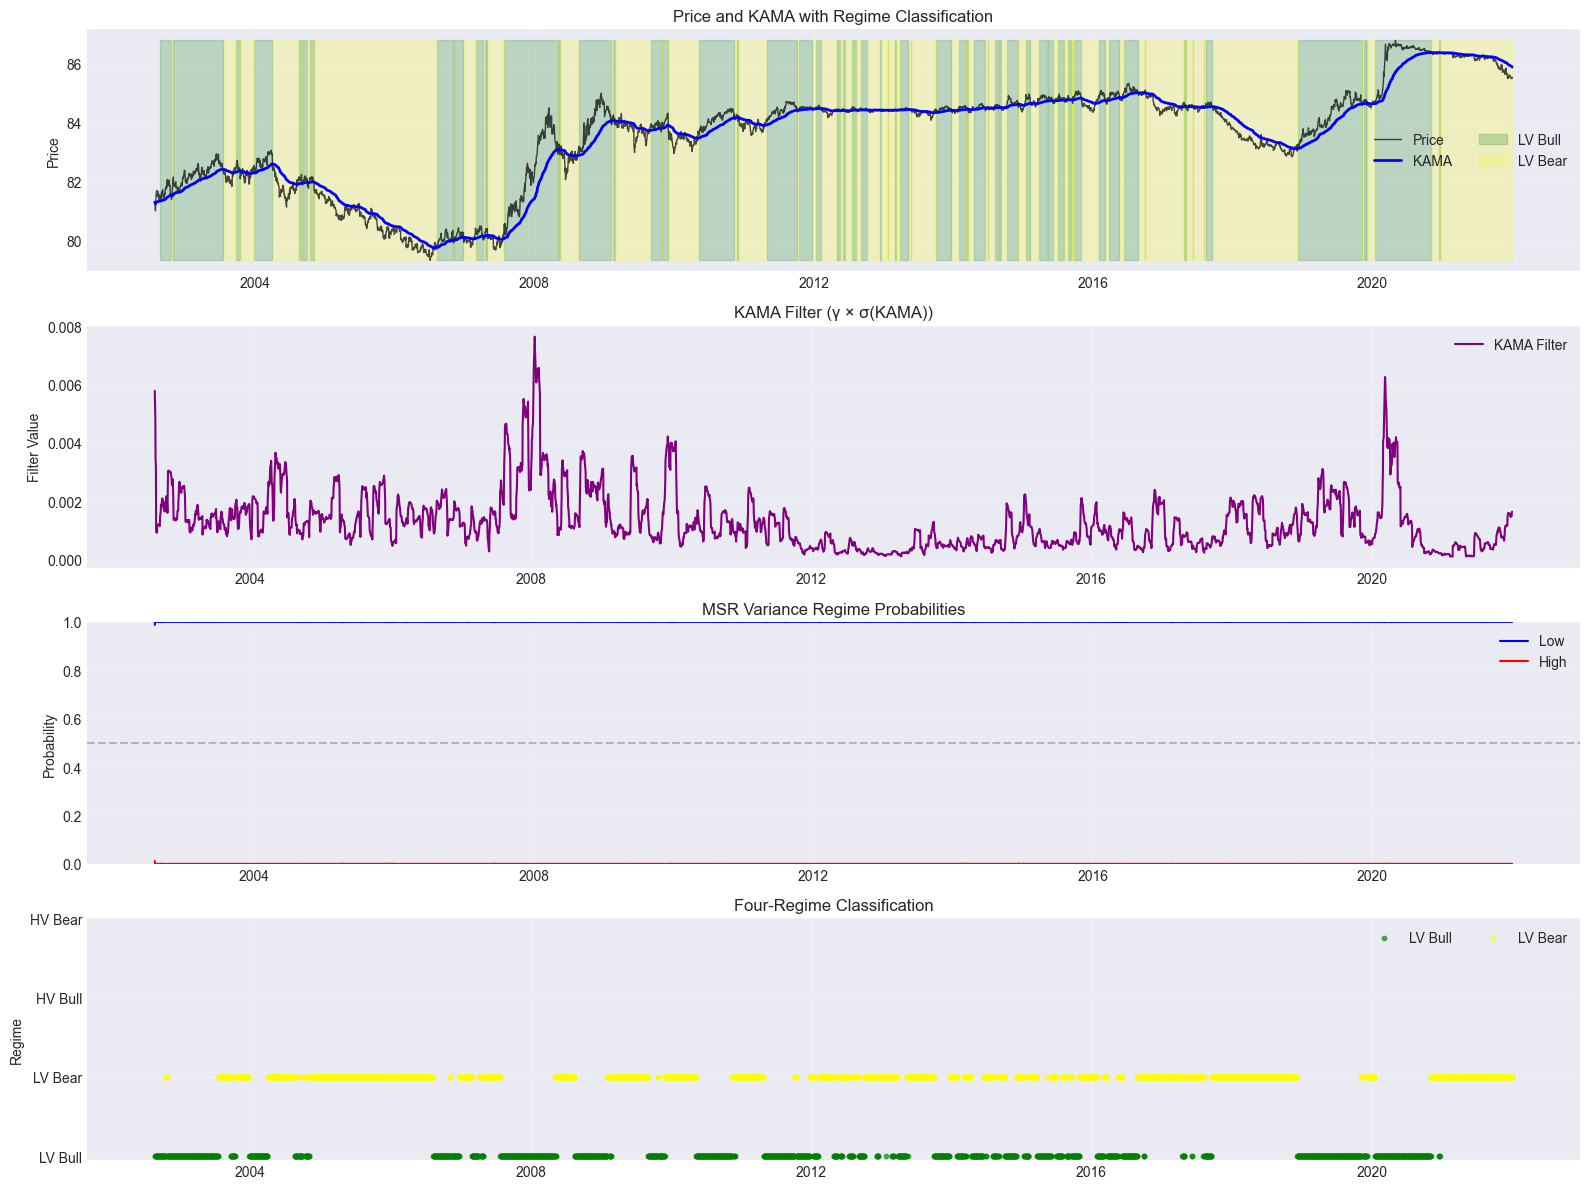

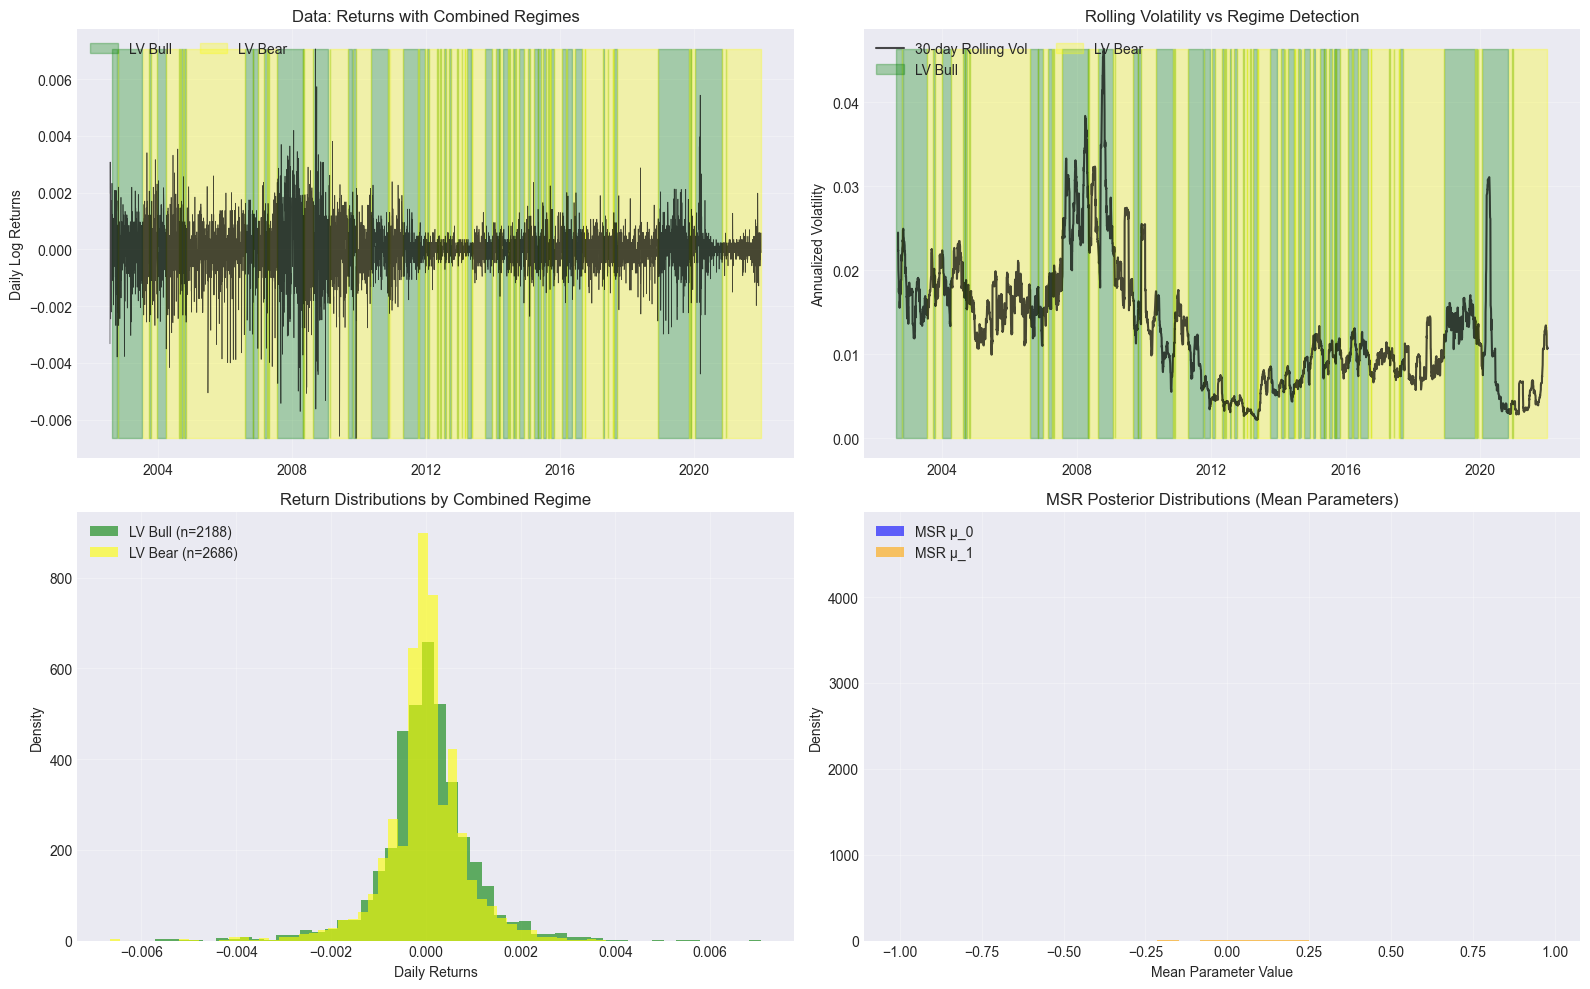

In [ ]:
asset_name = 'Vanguard Total International Stock ETF'
n_regimes = 2
sub_folder = 'us_traded_international_equity_etfs'
edte_sub_folder = edte.strftime('%Y%m%d')
load_and_analyze_KAMA_MSR_model(asset_name, n_regimes, sub_folder, edte_sub_folder)